In [39]:
### summary: TOP SCORES: 
#52.5% with gaussian naive bayes
#52.5% with k-nn with ~200 neighbors
#52.5% with logistic regression and C~1e-2
#52% with a 2 depth decision tree
#always going for 1 -> 50.7%

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score

matplotlib.style.use('ggplot')
%matplotlib inline

score_to_compute = 'roc_auc'
number_of_cv_folds = 5

In [40]:
import sklearn.cross_validation

numerai_data = pd.read_csv("./Datasets/numerai_training_data.csv")

#separating train and test
[validation_data, training_data] = sklearn.cross_validation.train_test_split(numerai_data, 
                                                                             test_size = 0.80, random_state = 13)
training_data = training_data.drop('validation', axis=1)
validation_data = validation_data.drop('validation', axis=1)

print('Size of datasets: total - %s, train - %s, test - %s' %(
        numerai_data.shape[0], training_data.shape[0], validation_data.shape[0]))

Size of datasets: total - 55038, train - 44031, test - 11007


In [41]:
#preprocessing the categorical feature c1

from sklearn import preprocessing

try:
    training_data["c1_int"] = training_data["c1"].apply(lambda x: int(x[3:]))
except Exception:
    le = preprocessing.LabelEncoder()
    le.fit_transform(list(set(training_data["c1"])))
    training_data["c1_int"] = le.transform(np.asarray(training_data["c1"]))

print "Categorical feature transformed:"
print training_data[["c1", "c1_int"]].head(5)

binaries = pd.get_dummies(training_data['c1'], prefix='bin_', prefix_sep='', dummy_na=False, columns=['c1'], sparse=False)
training_data = pd.concat([training_data, binaries], axis=1)

#features:
quant_features = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14']
binary_features = [c for c in training_data.columns if c.startswith('bin_')]
print ("\n\n\nQuant features are: %s" %','.join(quant_features))
print ("\n\n\nBinary features are: %s" %','.join(binary_features))

Categorical feature transformed:
          c1  c1_int
26146   c1_1       1
37399  c1_15      15
19573  c1_18      18
438     c1_5       5
17523   c1_9       9



Quant features are: f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14



Binary features are: bin_c1_1,bin_c1_10,bin_c1_11,bin_c1_12,bin_c1_13,bin_c1_14,bin_c1_15,bin_c1_16,bin_c1_17,bin_c1_18,bin_c1_19,bin_c1_20,bin_c1_21,bin_c1_22,bin_c1_23,bin_c1_24,bin_c1_3,bin_c1_4,bin_c1_5,bin_c1_6,bin_c1_7,bin_c1_8,bin_c1_9


In [42]:
training_data[['c1']+binary_features].head(5)

c1  bin_c1_1  bin_c1_10  bin_c1_11  bin_c1_12  bin_c1_13  bin_c1_14  \
26146   c1_1         1          0          0          0          0          0   
37399  c1_15         0          0          0          0          0          0   
19573  c1_18         0          0          0          0          0          0   
438     c1_5         0          0          0          0          0          0   
17523   c1_9         0          0          0          0          0          0   

       bin_c1_15  bin_c1_16  bin_c1_17    ...     bin_c1_22  bin_c1_23  \
26146          0          0          0    ...             0          0   
37399          1          0          0    ...             0          0   
19573          0          0          0    ...             0          0   
438            0          0          0    ...             0          0   
17523          0          0          0    ...             0          0   

       bin_c1_24  bin_c1_3  bin_c1_4  bin_c1_5  bin_c1_6  bin_c1_7  bin_c1_8  \
26146          0         0         0         0         0         0         0   
37399          0         0         0         0         0         0         0   
19573          0         0         0         0         0         0         0   
438            0         0         0         1         0         0         0   
17523          0         0         0         0         0         0         0   

       bin_c1_9  
26146         0  
37399         0  
19573         0  
438           0  
17523         1  

[5 rows x 24 columns]

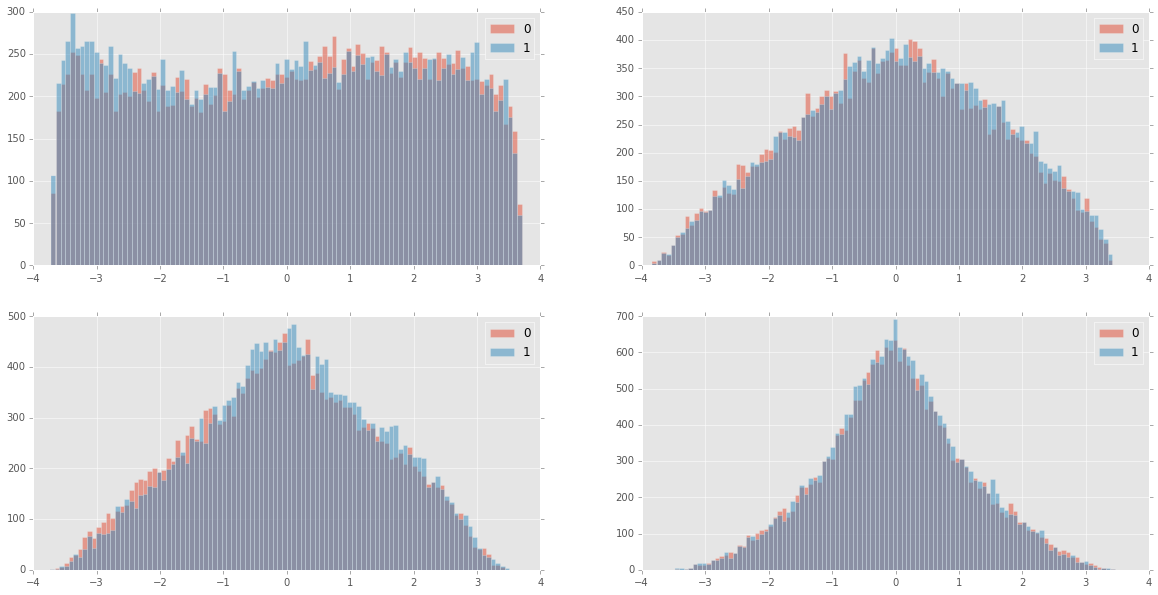

In [43]:
#PCA

from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import math

variance_cutoff = 0.80

#scaled_features:
scaled_features = map(lambda f: 'scaled_'+f, quant_features)

#centering and scaling
for f in scaled_features:
    training_data[f] = 0
training_data[scaled_features] = training_data.loc[:,quant_features].apply(lambda x: (x-np.mean(x))/np.std(x), axis=1)

#PCA
pca_ = PCA()
pca_.fit(training_data.loc[:,scaled_features])
principal_components_features = map(lambda t: t[0]+str(t[1]), zip(["PC_"]*len(scaled_features), range(1,len(scaled_features)+1)))
for f in principal_components_features:
    training_data[f] = 0
training_data.loc[:,principal_components_features] = pca_.transform(training_data[scaled_features])

l_principal_components = np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff)
principal_components_features = principal_components_features[0:l_principal_components]

plt.figure(figsize=(20,10))
for i in range(0,l_principal_components):
    ax = plt.subplot(math.ceil(math.sqrt(l_principal_components)), math.ceil(math.sqrt(l_principal_components)), i+1)
    bins = np.linspace(np.min(training_data.loc[:,principal_components_features[i]]), np.max(training_data.loc[:,principal_components_features[i]]), 100)
    ax.hist(training_data.ix[training_data.loc[:,'target']==0,principal_components_features[i]].tolist(), bins, alpha=0.5, label='0')
    ax.hist(training_data.ix[training_data.loc[:,'target']==1,principal_components_features[i]].tolist(), bins, alpha=0.5, label='1')
    ax.legend(loc='upper right')

plt.show()

in sample score: 0.522462051464, out of sample score: 0.526265649618


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:431: DeprecationWarning: The parameter 'store_covariance' is deprecated as of version 0.17 and will be removed in 0.19. The parameter is no longer necessary because the value is set via the estimator initialisation or set_params method.
  "set_params method.", DeprecationWarning)


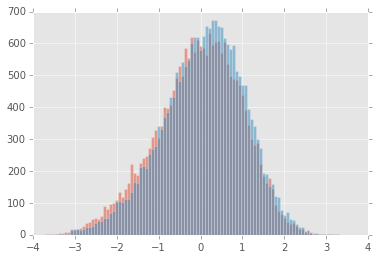

In [44]:
#LDA Projection on the vector of the 2 centroids + cv of LDA

from sklearn.lda import LDA
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score

LDA_features=quant_features

clf = sklearn.lda.LDA()
clf.fit(training_data[LDA_features], training_data['target'],store_covariance=True)
IS_score = roc_auc_score(training_data['target'], clf.predict(training_data[LDA_features]))
#clf.score(training_data[LDA_features], training_data['target'], scoring = score_to_compute)
CV_score = np.mean(cross_val_score(clf, training_data[LDA_features], training_data['target'], 
                                   cv=number_of_cv_folds, scoring = score_to_compute))

print "in sample score: %s, out of sample score: %s" %(IS_score,CV_score)

training_data['lda_dir1'] = clf.transform(training_data[LDA_features])

lda_components = ['lda_dir1']

ax = plt.subplot(1,1,1)
bins = np.linspace(np.min(training_data.loc[:,'lda_dir1']), np.max(training_data.loc[:,'lda_dir1']), 100)
ax.hist(training_data.ix[training_data.loc[:,'target']==0,'lda_dir1'].tolist(), bins, alpha=0.5, label='0')
ax.hist(training_data.ix[training_data.loc[:,'target']==1,'lda_dir1'].tolist(), bins, alpha=0.5, label='1')
plt.show()



In [45]:
#decision tree

#classification score with a single regression tree

from sklearn import tree
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

decision_features = quant_features+binary_features#principal_components_features#+binary_features

print 'decision features:\n' 
print decision_features

max_depths = range(1,30)

tuned_parameters = {'max_depth': range(1, 30)}

clf = GridSearchCV(tree.DecisionTreeClassifier(), tuned_parameters, cv=number_of_cv_folds,
                   scoring=score_to_compute, n_jobs=-1)
clf.fit(training_data[decision_features], training_data['target'])

print "Grid Scores:"
scores = pd.DataFrame([(t[0]['max_depth'], t[1]) for t in clf.grid_scores_], 
                   columns=['max_depth', 'mean_cv_score'])
print scores

print "Best params:"
print clf.best_params_

decision_tree_classifier = clf.best_estimator_



decision features:

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'bin_c1_1', 'bin_c1_10', 'bin_c1_11', 'bin_c1_12', 'bin_c1_13', 'bin_c1_14', 'bin_c1_15', 'bin_c1_16', 'bin_c1_17', 'bin_c1_18', 'bin_c1_19', 'bin_c1_20', 'bin_c1_21', 'bin_c1_22', 'bin_c1_23', 'bin_c1_24', 'bin_c1_3', 'bin_c1_4', 'bin_c1_5', 'bin_c1_6', 'bin_c1_7', 'bin_c1_8', 'bin_c1_9']
Grid Scores:
    max_depth  mean_cv_score
0           1       0.511370
1           2       0.517047
2           3       0.519390
3           4       0.520700
4           5       0.522622
5           6       0.520417
6           7       0.521936
7           8       0.516636
8           9       0.516071
9          10       0.517009
10         11       0.513955
11         12       0.514639
12         13       0.510660
13         14       0.507823
14         15       0.507057
15         16       0.507000
16         17       0.505857
17         18       0.506235
18         19       0.503155
19    

In [59]:
# Ensemble of trees: Random Forests
from sklearn.ensemble import RandomForestClassifier

decision_features = quant_features+binary_features

n_trees = range(20,300, 20)
depths = [None]+range(1, 30)

tuned_parameters = {'max_depth': depths, 'n_estimators':n_trees}

clf = GridSearchCV(sklearn.ensemble.RandomForestClassifier(), tuned_parameters, cv=number_of_cv_folds,
                   scoring=score_to_compute, n_jobs=-1)
clf.fit(training_data[decision_features], training_data['target'])

print "Grid Scores:"
scores = pd.DataFrame([(t[0]['n_estimators'], t[0]['max_depth'], t[1]) for t in clf.grid_scores_], 
                   columns=['n_estimators', 'max_depth', 'mean_cv_score'])
print scores

print "Best params:"
print clf.best_params_

forest_classifier = clf.best_estimator_


#forest_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators = 400, max_depth = 14)

Grid Scores:
   n_estimators max_depth  mean_cv_score
0            20      None       0.514822
Best params:
{'n_estimators': 20, 'max_depth': None}


In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
forest_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators = 400, max_depth = 14)

In [35]:
# Ensemble of trees: Adaboost
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

decision_features = quant_features+binary_features

n_trees = range(20,300, 20)
depths = [None]+range(1, 30)
scores = []

def get_cv_score(n_trees, depth):
    clf = sklearn.ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=depth), n_estimators = n_trees)
    cur_score= np.mean(cross_val_score(clf, training_data[decision_features], training_data["target"], 
                                   cv=number_of_cv_folds, scoring = score_to_compute))
    return (n_trees, depth, cur_score)
    
for i in range(len(n_trees)):
    scores += map(lambda d: get_cv_score(n_trees[i], d), depths)

print "Grid Scores:"
scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'mean_cv_score'])
print scores

print "Best params:"
best_index = np.argmax(scores['mean_cv_score'])
best_params = scores.iloc[best_index]
print best_params


print "Best Score:"
print scores.iloc[best_index]['mean_cv_score']

adaboost_classifier = sklearn.ensemble.AdaBoostClassifier(
    tree.DecisionTreeClassifier(max_depth=best_params['max_depth']), n_estimators = best_params['n_estimators'])


#adaboost_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators = 400, max_depth = 14)

Grid Scores:
    n_estimators  max_depth  mean_cv_score
0             20          1       0.525068
1             20         11       0.507429
2             20         21       0.510324
3             23          1       0.524116
4             23         11       0.502252
5             23         21       0.504578
6             26          1       0.523930
7             26         11       0.507760
8             26         21       0.510525
9             29          1       0.523460
10            29         11       0.499295
11            29         21       0.508628
Best params:
n_estimators     20.000000
max_depth         1.000000
mean_cv_score     0.525068
Name: 0, dtype: float64
Best Score:
0.525068429758


In [54]:
# Naive Bayes Gaussian

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

nb_gaussian_features = quant_features+binary_features#principal_components_features

nb_gaussian_classifier = GaussianNB()
nb_gaussian_classifier.fit(training_data[nb_gaussian_features], training_data["target"])
s = roc_auc_score(training_data['target'], nb_gaussian_classifier.predict(training_data[nb_gaussian_features]))
#nb_gaussian_classifier.score(training_data[nb_gaussian_features], training_data["target"])
m = np.mean(cross_val_score(nb_gaussian_classifier, training_data[nb_gaussian_features], training_data["target"],
                            cv=number_of_cv_folds, scoring = score_to_compute))
print "in sample score: %s, out of sample score: %s" %(s,m)

#TO DO: feature selection

# naive bayes gaussian classifier
nb_gaussian_classifier = GaussianNB()

in sample score: 0.522689695526, out of sample score: 0.529375089256


          C        IS        OS
0  0.000010  0.521777  0.527532
0  0.000018  0.521823  0.527766
0  0.000032  0.521567  0.527943
0  0.000056  0.521445  0.528084
0  0.000100  0.521798  0.528191
0  0.000178  0.522815  0.528304
0  0.000316  0.524012  0.528505
0  0.000562  0.524487  0.528808
0  0.001000  0.525132  0.529139
0  0.001778  0.525407  0.529411
0  0.003162  0.525814  0.529552
0  0.005623  0.525623  0.529549
0  0.010000  0.525127  0.529479
0  0.017783  0.525911  0.529372
0  0.031623  0.525585  0.529276
0  0.056234  0.526253  0.529235
0  0.100000  0.526573  0.529220
0  0.177828  0.526805  0.529224
0  0.316228  0.526648  0.529220
0  0.562341  0.526698  0.529217
0  1.000000  0.526676  0.529215
0  1.778279  0.526677  0.529215
0  3.162278  0.526722  0.529213
0  5.623413  0.526700  0.529212


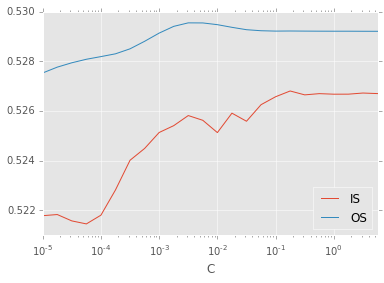

In [19]:
#Logistic regression
#TO DO: with and without regularization

import math

params = np.exp(np.arange(-5.0, 1.0,.25)*math.log(10))
log_reg_features = principal_components_features+binary_features

def apply_param(p):
    lreg_model = sklearn.linear_model.LogisticRegression(C=p)
    lreg_model.fit(training_data[log_reg_features], training_data["target"])
    IS = roc_auc_score(training_data['target'], lreg_model.predict(training_data[log_reg_features]))
    #lreg_model.score(training_data[log_reg_features], training_data["target"], scoring = score_to_compute)
    OS = np.mean(cross_val_score(lreg_model, training_data[log_reg_features], training_data["target"],
                                 cv=10, scoring = score_to_compute))
    return pd.DataFrame([np.array([p, IS, OS])], columns=['C', 'IS', 'OS']) 

scores = pd.concat(map(apply_param, params))
scores.plot(x='C',logx=True)
print scores

#log reg classifier
best_p = 0.01
lreg_classifier = sklearn.linear_model.LogisticRegression(C=best_p)


['lda_dir1']
             training_score  validation_score
n_neighbors                                  
11                        0          0.505852
18                        0          0.501526
32                        0          0.504948
57                        0          0.504956
101                       0          0.508824
178                       0          0.514099
317                       0          0.519308
563                       0          0.521381
1001                      0          0.526966
1779                      0          0.528892
3163                      0          0.530087
5624                      0          0.532198


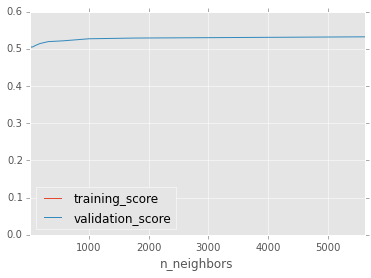

In [12]:
#k-nn
from sklearn.neighbors import KNeighborsClassifier
import math

n_neighbors = map(lambda x:int(math.ceil(x)), np.exp(np.arange(1.0, 4.0,.25)*math.log(10)).tolist())
k_nn_features = lda_components
print k_nn_features

def cv_score(par):
    clf = KNeighborsClassifier(n_neighbors=par)
    clf.fit(training_data[k_nn_features], training_data["target"])
    s = roc_auc_score(training_data['target'], clf.predict(training_data[k_nn_features]))
    #clf.score(training_data[k_nn_features], training_data["target"], scoring = score_to_compute)
    m = np.mean(cross_val_score(clf, training_data[k_nn_features], training_data["target"], 
                                cv=5, scoring = score_to_compute))
    dat = np.array([par, s, m])
    return pd.DataFrame([dat],columns=['n_neighbors','training_score', 'validation_score'])

k_nn_scores = pd.concat(map(cv_score, n_neighbors))
k_nn_scores.index = k_nn_scores['n_neighbors']
k_nn_scores.drop('n_neighbors',axis=1, inplace=True)

print k_nn_scores
k_nn_scores.plot(legend=True, grid=True)


#k-nn classifier
best_nn = 3000
k_nn_classifier = KNeighborsClassifier(best_nn)



In [17]:
#TO DO: 
#try QDA in case covariance changes | y
#try votes of k-nn on each principal component + the LDA axis - first try to figure out if that actually makes sense - does it have a chance to work?


In [17]:
#TO DO:
#ensemble model of:
# - naive bayes gaussian on original data -> global classif, 
# - 3000-nn on LDA space -> local classif
# - random forest -> local classif
# logistic regression with all features + c1 binarized or just the LDA components with c1 binarized -> global classif

from sklearn.ensemble import VotingClassifier
from sklearn import cross_validation

ensemble_classifiers = [nb_gaussian_classifier, k_nn_classifier, lreg_classifier, forest_classifier]

# Training classifiers
ensemble_classifier = VotingClassifier(estimators=[('nbg', nb_gaussian_classifier), ('knn', k_nn_classifier), 
                                                   ('lreg', lreg_classifier), ('forest', forest_classifier)],
                        voting='soft')

ensemble_classifier = ensemble_classifier.fit(training_data[quant_features+lda_components+principal_components_features+binary_features],training_data['target'])

for clf, label in zip([nb_gaussian_classifier, k_nn_classifier, lreg_classifier, forest_classifier, ensemble_classifier], [
        'Naive Bayes Gaussian', 'K-nn + LDA', 'logistic regression', 'Forest', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, training_data[
            quant_features+lda_components+principal_components_features+binary_features],training_data['target'], 
                                              cv=5, scoring = score_to_compute)
    print(score_to_compute+": %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

#predict probas, scale to [0;1] and combine them: majority vote (average of the majority), or average of probas

#Out of sample:
# 1. project new observations to the LDA space
# 2. estimate the probabilities from the three classifiers
# 3. combine them
# 4. make predictions



roc_auc: 0.5329 (+/- 0.0066) [Naive Bayes Gaussian]
roc_auc: 0.5333 (+/- 0.0054) [K-nn + LDA]
roc_auc: 0.5265 (+/- 0.0084) [logistic regression]
roc_auc: 0.5327 (+/- 0.0046) [Forest]
roc_auc: 0.5350 (+/- 0.0065) [Ensemble]


In [24]:
# correlation between classifiers:
import numpy as np

classifiers = [nb_gaussian_classifier, k_nn_classifier, lreg_classifier, forest_classifier]

for clf in classifiers:
    clf.fit(training_data[quant_features+lda_components+principal_components_features+binary_features], training_data["target"])

probas = np.zeros(shape=[training_data.shape[0],len(classifiers)])
predictions = np.zeros(shape=[training_data.shape[0],len(classifiers)])
for i in range(len(classifiers)):
    #probas[:,i] = classifiers[i].predict_proba(
    #    training_data[quant_features+lda_components+principal_components_features+binary_features])[:,1]
    predictions[:,i] = classifiers[i].predict(
        training_data[quant_features+lda_components+principal_components_features+binary_features])


print np.corrcoef(np.transpose(predictions))
#Strong correlation between classifiers = BAD -> probably why the ensemble model isn't better. 
#Essentially the ensemble fails to reduce bias


[[ 1.          0.61538028  0.6181035   0.67209509]
 [ 0.61538028  1.          0.54967293  0.66537291]
 [ 0.6181035   0.54967293  1.          0.58046436]
 [ 0.67209509  0.66537291  0.58046436  1.        ]]
